In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings("ignore")

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [3]:
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [4]:
sp500['Symbol'] = sp500['Symbol'].replace('.','-')

In [5]:
symbols_list = sp500['Symbol'].unique().tolist()

In [6]:
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

In [7]:
#df = yf.download(tickers = symbols_list, start = start_date, end = end_date)

In [8]:
# remove delisted stocks
symbols_list.remove('BRK.B')
symbols_list.remove('VLTO')

In [9]:
symbols_list.remove('BF.B')

In [10]:
df = yf.download(tickers = symbols_list, start = start_date, end = end_date)

[*********************100%%**********************]  500 of 500 completed


In [11]:
df.stack() #for each date, there are symbols are their prices

Adj Close       Close        High         Low        Open  \
Date                                                                          
2015-09-29 A      31.534710   33.740002   34.060001   33.240002   33.360001   
           AAL    37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL   24.716066   27.264999   28.377501   26.965000   28.207500   
           ABBV   37.024628   52.790001   54.189999   51.880001   53.099998   
           ABT    33.807270   39.500000   40.150002   39.029999   39.259998   
...                     ...         ...         ...         ...         ...   
2023-09-26 YUM   123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH   111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA  223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION   33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS   176.447540  176.869995  178.449997  176.270004  176.580002   

                      Volume  
Date                          
2015-09-29 A       2252400.0  
           AAL     7478800.0  
           AAPL  293461600.0  
           ABBV   12842800.0  
           ABT    12287500.0  
...                      ...  
2023-09-26 YUM     1500600.0  
           ZBH     3610500.0  
           ZBRA     355400.0  
           ZION    1586100.0  
           ZTS     1463200.0  

[989155 rows x 6 columns]

In [12]:
df = df.stack()

In [13]:
df

Adj Close       Close        High         Low        Open  \
Date                                                                          
2015-09-29 A      31.534710   33.740002   34.060001   33.240002   33.360001   
           AAL    37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL   24.716066   27.264999   28.377501   26.965000   28.207500   
           ABBV   37.024628   52.790001   54.189999   51.880001   53.099998   
           ABT    33.807270   39.500000   40.150002   39.029999   39.259998   
...                     ...         ...         ...         ...         ...   
2023-09-26 YUM   123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH   111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA  223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION   33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS   176.447540  176.869995  178.449997  176.270004  176.580002   

                      Volume  
Date                          
2015-09-29 A       2252400.0  
           AAL     7478800.0  
           AAPL  293461600.0  
           ABBV   12842800.0  
           ABT    12287500.0  
...                      ...  
2023-09-26 YUM     1500600.0  
           ZBH     3610500.0  
           ZBRA     355400.0  
           ZION    1586100.0  
           ZTS     1463200.0  

[989155 rows x 6 columns]

In [14]:
df.index.names = ['date', 'ticker']

In [15]:
df.columns = df.columns.str.lower()

In [16]:
df.columns 

Index(['adj close', 'close', 'high', 'low', 'open', 'volume'], dtype='object')

# Features and technical indicators for each stock

In [17]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)- 1)*((np.log(df['adj close']) - np.log(df['open']))**2)


In [18]:
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534710   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716066   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024628   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807270   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol  
date       ticker                                 
2015-09-29 A         2252400.0         -0.000926  
           AAL       7478800.0         -0.000443  
           AAPL    293461600.0         -0.005441  
           ABBV     12842800.0         -0.049280  
           ABT      12287500.0         -0.008237  
...                        ...               ...  
2023-09-26 YUM       1500600.0          0.000037  
           ZBH       3610500.0          0.000161  
           ZBRA       355400.0          0.000133  
           ZION      1586100.0          0.000292  
           ZTS       1463200.0          0.000075  

[989155 rows x 7 columns]

In [19]:
df['rsi'] = df.groupby(level = 1)["adj close"].transform(lambda x: pandas_ta.rsi(close = x, length = 20)) #group by each ticker

<Axes: xlabel='date'>

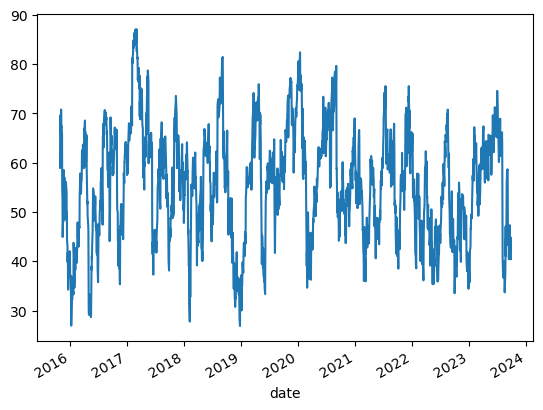

In [20]:
df.xs('AAPL', level = 1)['rsi'].plot()

In [21]:
'''
The length parameter typically represents the number of periods used to calculate the moving average and standard deviation for constructing the Bollinger Bands. In your case, length=20 means that a 20-period simple moving average (SMA) will be calculated for the middle band, and the upper and lower bands will be based on the standard deviation of the last 20 closing prices.
'''
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

In [22]:
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534710   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716066   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024628   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807270   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000926        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005441        NaN       NaN   
           ABBV     12842800.0         -0.049280        NaN       NaN   
           ABT      12287500.0         -0.008237        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 YUM       1500600.0          0.000037  36.057200  4.821521   
           ZBH       3610500.0          0.000161  31.893252  4.749948   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZION      1586100.0          0.000292  46.707775  3.527329   
           ZTS       1463200.0          0.000075  42.623483  5.161192   

                     bb_mid   bb_high  
date       ticker                      
2015-09-29 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2023-09-26 YUM     4.851489  4.881456  
           ZBH     4.789615  4.829283  
           ZBRA    5.539167  5.677342  
           ZION    3.582765  3.638202  
           ZTS     5.220007  5.278822  

[989155 rows x 11 columns]

In [23]:
#apr using custom function
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                       low = stock_data['low'],
                       close = stock_data['close'],
                       length = 14)
    return atr.sub(atr.mean()).div(atr.std()) #normal

In [24]:
df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)

In [25]:
def compute_macd(close):#takes in close price
    macd = pandas_ta.macd(close = close, length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
#nromalizaiton data because need to use it in clustering method

In [26]:
df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)

In [27]:
#rsi data is not normalized

In [28]:
df['dollar_volume'] = df['adj close']*df['volume']/1000000

# Aggregate data on monthly level and filter top 150 most liquid stocks for each month

In [29]:
#for each of the 5 metrics, take value for last 
#date of the month and for dollar volume, it is the average 
#dollar volumen across month for each stock

In [30]:
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')
#resample to monthly and then take the mean and then restack it

dollar_volume
date       ticker               
2015-09-30 A           76.355233
           AAL        432.669003
           AAPL      6949.871235
           ABBV       464.720961
           ABT        392.734892
...                          ...
2023-09-30 YUM        176.806022
           ZBH        192.191763
           ZBRA       105.780863
           ZION       100.279835
           ZTS        288.993350

[47686 rows x 1 columns]

In [31]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

In [32]:
df.unstack()[last_cols].resample('M').last().stack('ticker')

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2015-09-30 A        32.086140         -0.001155        NaN       NaN   
           AAL      37.027870          0.000050        NaN       NaN   
           AAPL     24.997089         -0.003307        NaN       NaN   
           ABBV     38.160820         -0.044070        NaN       NaN   
           ABT      34.423500         -0.008007        NaN       NaN   
...                       ...               ...        ...       ...   
2023-09-30 YUM     123.426186          0.000037  36.057200  4.821521   
           ZBH     111.992920          0.000161  31.893252  4.749948   
           ZBRA    223.960007          0.000133  29.494977  5.400991   
           ZION     33.581326          0.000292  46.707775  3.527329   
           ZTS     176.447540          0.000075  42.623483  5.161192   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2015-09-30 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2023-09-30 YUM     4.851489  4.881456  0.142547 -1.363696  
           ZBH     4.789615  4.829283 -0.381708 -0.881067  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791  
           ZION    3.582765  3.638202 -0.161699 -0.164625  
           ZTS     5.220007  5.278822  0.651515 -1.188278  

[47686 rows x 8 columns]

In [33]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          136.213758   39.086586         -0.001902  73.421606   
           AAL        287.915804   39.429932         -0.000966  40.718986   
           AAPL      4034.583704   26.924873         -0.003119  55.537319   
           ABBV       343.971764   41.160297         -0.053947  49.376843   
           ABT        213.736346   38.669395         -0.009962  56.962576   
...                          ...         ...               ...        ...   
2023-09-30 YUM        176.806022  123.426186          0.000037  36.057200   
           ZBH        192.191763  111.992920          0.000161  31.893252   
           ZBRA       105.780863  223.960007          0.000133  29.494977   
           ZION       100.279835   33.581326          0.000292  46.707775   
           ZTS        288.993350  176.447540          0.000075  42.623483   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.547568  3.620020  3.692471 -1.033887  0.567157  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418772  
           AAPL    3.284211  3.327527  3.370842 -0.967900 -0.142790  
           ABBV    3.745051  3.793320  3.841588 -0.526809  0.145677  
           ABT     3.665571  3.687430  3.709289 -1.064842  0.335557  
...                     ...       ...       ...       ...       ...  
2023-09-30 YUM     4.821521  4.851489  4.881456  0.142547 -1.363696  
           ZBH     4.749948  4.789615  4.829283 -0.381708 -0.881067  
           ZBRA    5.400991  5.539167  5.677342 -0.057389 -1.600791  
           ZION    3.527329  3.582765  3.638202 -0.161699 -0.164625  
           ZTS     5.161192  5.220007  5.278822  0.651515 -1.188278  

[46704 rows x 9 columns]

In [34]:
#calculate 5 year rolling average of dollar volume for each stock before filtering
#data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())


In [35]:
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A                 NaN   39.086586         -0.001902  73.421606   
           AAL               NaN   39.429932         -0.000966  40.718986   
           AAPL              NaN   26.924873         -0.003119  55.537319   
           ABBV              NaN   41.160297         -0.053947  49.376843   
           ABT               NaN   38.669395         -0.009962  56.962576   
...                          ...         ...               ...        ...   
2023-09-30 YUM        186.457631  123.426186          0.000037  36.057200   
           ZBH        170.432570  111.992920          0.000161  31.893252   
           ZBRA       124.051293  223.960007          0.000133  29.494977   
           ZION        88.382872   33.581326          0.000292  46.707775   
           ZTS        297.568758  176.447540          0.000075  42.623483   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.547568  3.620020  3.692471 -1.033887  0.567157  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418772  
           AAPL    3.284211  3.327527  3.370842 -0.967900 -0.142790  
           ABBV    3.745051  3.793320  3.841588 -0.526809  0.145677  
           ABT     3.665571  3.687430  3.709289 -1.064842  0.335557  
...                     ...       ...       ...       ...       ...  
2023-09-30 YUM     4.821521  4.851489  4.881456  0.142547 -1.363696  
           ZBH     4.749948  4.789615  4.829283 -0.381708 -0.881067  
           ZBRA    5.400991  5.539167  5.677342 -0.057389 -1.600791  
           ZION    3.527329  3.582765  3.638202 -0.161699 -0.164625  
           ZTS     5.161192  5.220007  5.278822  0.651515 -1.188278  

[46704 rows x 9 columns]

In [36]:
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending = False))

In [37]:
data = data[data['dollar_vol_rank']< 150].drop(['dollar_volume', 'dollar_vol_rank'], axis = 1)

In [38]:
#calculate monthly_returns for different time horizons as features

In [39]:
#select 2020-09-30 data, first index
df.xs('2020-09-30', level = 0)

,adj close,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
ticker,,,,,,,,,,,,,,
A,98.681168,100.940002,101.889999,100.309998,100.540001,1362200.0,-0.000012,57.767417,4.545557,4.581202,4.616847,0.047192,0.063119,134.423487
AAL,12.290000,12.290000,12.920000,12.220000,12.320000,65428100.0,0.001549,46.563822,2.542827,2.629867,2.716906,-0.847713,-0.122289,804.111347
AAPL,113.604187,115.809998,117.260002,113.620003,113.790001,142675200.0,0.000496,53.282709,4.634371,4.726292,4.818213,1.706681,-0.608079,16208.500103
ABBV,76.284210,87.589996,88.440002,86.809998,87.000000,8209300.0,-0.006501,39.881897,4.322225,4.367721,4.413216,-0.457273,-1.218601,626.239967
ABT,102.994148,108.830002,109.480003,105.739998,105.989998,9487000.0,0.000287,58.959819,4.574032,4.610706,4.647380,1.175836,0.269895,977.105484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,86.087242,91.300003,92.529999,90.760002,91.120003,1735200.0,-0.001060,47.023283,4.437065,4.482010,4.526955,0.290456,-0.712699,149.378583
ZBH,129.025726,132.174759,133.912628,129.699036,129.902908,1040300.0,0.000493,49.661547,4.828917,4.882290,4.935663,0.921846,-0.374297,134.225463
ZBRA,252.460007,252.460007,259.390015,250.449997,258.070007,596400.0,0.000428,43.614216,5.477198,5.551052,5.624906,0.102314,-0.700047,150.567148


In [40]:
#select apple data, second index
g = df.xs('AAPL', level = 1)
lags = [1,2,3,6,9,12]
outlier_cutoff = 0.005 #outlier values in return; all values above threshold wil be assigned threshold of that percentile

In [41]:
for lag in lags:
    g[f'return_{lag}m'] = (g['adj close']. pct_change(lag).pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff), upper = x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1))

In [42]:
def calculate_returns(df):
    outlier_cutoff = 0.005 #outlier values in return; all values above threshold wil be assigned threshold of that percentile
    lags = [1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']. pct_change(lag).pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff), upper = x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1))
    
    return df

In [43]:
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534164         -0.000363  41.051767  3.849110   
           AAPL     39.818516         -0.000945  69.196764  3.597289   
           ABBV     68.772316         -0.029822  55.247934  4.215227   
           ABT      48.969311         -0.004349  53.844927  3.902136   
           ACN     130.375107         -0.003359  69.365417  4.810123   
...                       ...               ...        ...       ...   
2023-09-30 VRTX    351.690002          0.000037  52.406728  5.838959   
           VZ       32.300549         -0.000067  42.222474  3.499366   
           WFC      40.290813          0.000136  40.920287  3.709473   
           WMT     161.898697          0.000011  54.722512  5.077929   
           XOM     115.355156          0.000068  59.440184  4.704273   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.644164  3.691040 -0.906642 -0.039275   0.096808   
           ABBV    4.261600  4.307973  0.375557  0.473814   0.022728   
           ABT     3.925710  3.949284 -1.040044  0.276133   0.021276   
           ACN     4.849805  4.889487 -0.986514  0.352342   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 VRTX    5.859127  5.879295  0.029799  0.027907   0.009617   
           VZ      3.531604  3.563843 -1.078816 -0.350385  -0.056890   
           WFC     3.749849  3.790225 -0.558742 -0.282325  -0.015500   
           WMT     5.095615  5.113302 -0.196379  0.399459  -0.000676   
           XOM     4.744375  4.784477  0.601335  1.400623   0.046947   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 VRTX    -0.000923  -0.000208   0.018495   0.022140    0.016337  
           VZ      -0.016122  -0.033458  -0.021495  -0.014100   -0.006158  
           WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255  
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  

[10334 rows x 14 columns]

# download fama french factors 

In [44]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01,-3.36,0.34,0.43,-1.27,0.46
2010-02,3.40,1.51,3.23,-0.27,1.43
2010-03,6.31,1.85,2.21,-0.65,1.69
2010-04,2.00,4.98,2.89,0.69,1.72
2010-05,-7.89,0.04,-2.44,1.30,-0.21
...,...,...,...,...,...
2023-07,3.21,2.86,4.11,-0.57,0.57
2023-08,-2.39,-3.65,-1.06,3.43,-2.37
2023-09,-5.24,-1.80,1.52,1.86,-0.83


In [45]:
factor_data.index = factor_data.index.to_timestamp()

In [46]:
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-01,-3.36,0.34,0.43,-1.27,0.46
2010-02-01,3.40,1.51,3.23,-0.27,1.43
2010-03-01,6.31,1.85,2.21,-0.65,1.69
2010-04-01,2.00,4.98,2.89,0.69,1.72
2010-05-01,-7.89,0.04,-2.44,1.30,-0.21
...,...,...,...,...,...
2023-07-01,3.21,2.86,4.11,-0.57,0.57
2023-08-01,-2.39,-3.65,-1.06,3.43,-2.37
2023-09-01,-5.24,-1.80,1.52,1.86,-0.83


In [47]:
#get values last month and divide percentage values by 100
factor_data = factor_data.resample('M').last().div(100)

In [48]:
factor_data.index.name = 'date'

In [49]:
factor_data = factor_data.join(data['return_1m']).sort_index()

In [50]:
factor_data.xs('AAPL', level = 1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2017-10-31,0.0225,-0.0194,0.0020,0.0093,-0.0325,0.096808
2017-11-30,0.0312,-0.0033,-0.0003,0.0316,-0.0005,0.020278
2017-12-31,0.0106,-0.0107,0.0006,0.0074,0.0169,-0.015246
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096,-0.010636
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237,0.068185


In [51]:
#filter out stocks with less than 10 months of data becuase we will use rolling window of 2 years

In [52]:
observations = factor_data.groupby(level = 1).size()

In [53]:
valid_stocks = observations[observations >= 10]

In [54]:
factor_data.index

MultiIndex([('2017-10-31',  'AAL'),
            ('2017-10-31', 'AAPL'),
            ('2017-10-31', 'ABBV'),
            ('2017-10-31',  'ABT'),
            ('2017-10-31',  'ACN'),
            ('2017-10-31', 'ADBE'),
            ('2017-10-31',  'AIG'),
            ('2017-10-31', 'AMAT'),
            ('2017-10-31', 'AMGN'),
            ('2017-10-31', 'AMZN'),
            ...
            ('2023-09-30',  'UNP'),
            ('2023-09-30',  'UPS'),
            ('2023-09-30',  'USB'),
            ('2023-09-30',    'V'),
            ('2023-09-30',  'VLO'),
            ('2023-09-30', 'VRTX'),
            ('2023-09-30',   'VZ'),
            ('2023-09-30',  'WFC'),
            ('2023-09-30',  'WMT'),
            ('2023-09-30',  'XOM')],
           names=['date', 'ticker'], length=10334)

In [55]:
factor_data.index.get_level_values('ticker')

Index(['AAL', 'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMAT', 'AMGN',
       'AMZN',
       ...
       'UNP', 'UPS', 'USB', 'V', 'VLO', 'VRTX', 'VZ', 'WFC', 'WMT', 'XOM'],
      dtype='object', name='ticker', length=10334)

In [56]:
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10305 rows x 6 columns]

In [57]:
#calculate rolling factor betas

In [58]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332654 -0.165644  0.267343  0.310367  0.106902
           WFC     1.121746  0.300522  2.061532 -0.439488 -1.517557
           WMT     0.700557 -0.315602 -0.413431 -0.142908  0.508470
           XOM     0.983510 -1.093758  1.756776 -0.640867 -0.368454

[10305 rows x 5 columns]

In [59]:
data = data.join((betas.groupby('ticker').shift())) #know beta for october in nonvember for example, so shift

In [60]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534164         -0.000363  41.051767  3.849110   
           AAPL     39.818516         -0.000945  69.196764  3.597289   
           ABBV     68.772316         -0.029822  55.247934  4.215227   
           ABT      48.969311         -0.004349  53.844927  3.902136   
           ACN     130.375107         -0.003359  69.365417  4.810123   
...                       ...               ...        ...       ...   
2023-09-30 VRTX    351.690002          0.000037  52.406728  5.838959   
           VZ       32.300549         -0.000067  42.222474  3.499366   
           WFC      40.290813          0.000136  40.920287  3.709473   
           WMT     161.898697          0.000011  54.722512  5.077929   
           XOM     115.355156          0.000068  59.440184  4.704273   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.644164  3.691040 -0.906642 -0.039275   0.096808   
           ABBV    4.261600  4.307973  0.375557  0.473814   0.022728   
           ABT     3.925710  3.949284 -1.040044  0.276133   0.021276   
           ACN     4.849805  4.889487 -0.986514  0.352342   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 VRTX    5.859127  5.879295  0.029799  0.027907   0.009617   
           VZ      3.531604  3.563843 -1.078816 -0.350385  -0.056890   
           WFC     3.749849  3.790225 -0.558742 -0.282325  -0.015500   
           WMT     5.095615  5.113302 -0.196379  0.399459  -0.000676   
           XOM     4.744375  4.784477  0.601335  1.400623   0.046947   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702   
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228   
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026   
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294   
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728   
...                      ...        ...        ...        ...         ...   
2023-09-30 VRTX    -0.000923  -0.000208   0.018495   0.022140    0.016337   
           VZ      -0.016122  -0.033458  -0.021495  -0.014100   -0.006158   
           WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255   
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256   
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN       NaN  
           ACN          NaN       NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...       ...  
2023-09-30 VRTX    0.504874 -0.411220 -0.481330  0.057087  0.943374  
           VZ      0.302530 -0.212071  0.344588  0.318169  0.000827  
           WFC     1.137639  0.314483  2.009073 -0.404336 -1.468839  
           WMT     0.740056 -0.261892 -0.522675 -0.126428  0.642625  
           XOM     1.005968 -1.051369  1.707834 -0.675680 -0.284025  

[10334 rows x 19 columns]

In [61]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']

In [62]:
#na values imputed with mean
data.loc[:, factors] = data.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean())) #fill mssing values with mean

In [63]:
data=data.dropna()
data = data.drop('adj close', axis = 1)
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051767  3.849110  3.921750  3.994389   
           AAPL           -0.000945  69.196764  3.597289  3.644164  3.691040   
           ABBV           -0.029822  55.247934  4.215227  4.261600  4.307973   
           ABT            -0.004349  53.844927  3.902136  3.925710  3.949284   
           ACN            -0.003359  69.365417  4.810123  4.849805  4.889487   
...                             ...        ...       ...       ...       ...   
2023-09-30 VRTX            0.000037  52.406728  5.838959  5.859127  5.879295   
           VZ             -0.000067  42.222474  3.499366  3.531604  3.563843   
           WFC             0.000136  40.920287  3.709473  3.749849  3.790225   
           WMT             0.000011  54.722512  5.077929  5.095615  5.113302   
           XOM             0.000068  59.440184  4.704273  4.744375  4.784477   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018697  -0.014108   0.022981  -0.023860   
           AAPL   -0.906642 -0.039275   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473814   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276133   0.021276   0.034308   0.034801   
           ACN    -0.986514  0.352342   0.064180   0.048455   0.037203   
...                     ...       ...        ...        ...        ...   
2023-09-30 VRTX    0.029799  0.027907   0.009617  -0.000923  -0.000208   
           VZ     -1.078816 -0.350385  -0.056890  -0.016122  -0.033458   
           WFC    -0.558742 -0.282325  -0.015500  -0.057917  -0.013554   
           WMT    -0.196379  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275749 -0.271695   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199023   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166700   
...                      ...        ...         ...       ...       ...   
2023-09-30 VRTX     0.018495   0.022140    0.016337  0.504874 -0.411220   
           VZ      -0.021495  -0.014100   -0.006158  0.302530 -0.212071   
           WFC      0.016712   0.000702    0.003255  1.137639  0.314483   
           WMT      0.017574   0.016553    0.020256  0.740056 -0.261892   
           XOM      0.012838   0.008747    0.027037  1.005968 -1.051369   

                        HML       RMW       CMA  
date       ticker                                
2017-10-31 AAL     0.601339  0.458860  0.563294  
           AAPL   -0.591145  0.647780  0.458079  
           ABBV   -0.033100  0.241980  0.164919  
           ABT    -0.529383  0.252404  0.970210  
           ACN    -0.328214  0.267790  0.168882  
...                     ...       ...       ...  
2023-09-30 VRTX   -0.481330  0.057087  0.943374  
           VZ      0.344588  0.318169  0.000827  
           WFC     2.009073 -0.404336 -1.468839  
           WMT    -0.522675 -0.126428  0.642625  
           XOM     1.707834 -0.675680 -0.284025  

[10082 rows x 18 columns]

In [64]:
#for each month, form portfolio with some stocks from datset

In [65]:
#stocks in each portfolio for a month, which stocks to use based on clustering, magnitude

In [66]:
#for each month fit a kmeans clustering to approach to use for predictions

In [67]:
from sklearn.cluster import KMeans

In [87]:
from sklearn.cluster import KMeans

def get_clusters(df):
    target_rsi_values = [30,45,55,70]
    initial_centroids = np.zeros((len(target_rsi_values), 18))
    initial_centroids[:, 1] = target_rsi_values
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init=initial_centroids).fit(df).labels_
    return df

In [88]:
# Assuming 'date' is a column in your DataFrame
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

In [89]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051767  3.849110  3.921750  3.994389   
           AAPL           -0.000945  69.196764  3.597289  3.644164  3.691040   
           ABBV           -0.029822  55.247934  4.215227  4.261600  4.307973   
           ABT            -0.004349  53.844927  3.902136  3.925710  3.949284   
           ACN            -0.003359  69.365417  4.810123  4.849805  4.889487   
...                             ...        ...       ...       ...       ...   
2023-09-30 VRTX            0.000037  52.406728  5.838959  5.859127  5.879295   
           VZ             -0.000067  42.222474  3.499366  3.531604  3.563843   
           WFC             0.000136  40.920287  3.709473  3.749849  3.790225   
           WMT             0.000011  54.722512  5.077929  5.095615  5.113302   
           XOM             0.000068  59.440184  4.704273  4.744375  4.784477   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018697  -0.014108   0.022981  -0.023860   
           AAPL   -0.906642 -0.039275   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473814   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276133   0.021276   0.034308   0.034801   
           ACN    -0.986514  0.352342   0.064180   0.048455   0.037203   
...                     ...       ...        ...        ...        ...   
2023-09-30 VRTX    0.029799  0.027907   0.009617  -0.000923  -0.000208   
           VZ     -1.078816 -0.350385  -0.056890  -0.016122  -0.033458   
           WFC    -0.558742 -0.282325  -0.015500  -0.057917  -0.013554   
           WMT    -0.196379  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275749 -0.271695   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199023   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166700   
...                      ...        ...         ...       ...       ...   
2023-09-30 VRTX     0.018495   0.022140    0.016337  0.504874 -0.411220   
           VZ      -0.021495  -0.014100   -0.006158  0.302530 -0.212071   
           WFC      0.016712   0.000702    0.003255  1.137639  0.314483   
           WMT      0.017574   0.016553    0.020256  0.740056 -0.261892   
           XOM      0.012838   0.008747    0.027037  1.005968 -1.051369   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601339  0.458860  0.563294        1  
           AAPL   -0.591145  0.647780  0.458079        3  
           ABBV   -0.033100  0.241980  0.164919        2  
           ABT    -0.529383  0.252404  0.970210        2  
           ACN    -0.328214  0.267790  0.168882        3  
...                     ...       ...       ...      ...  
2023-09-30 VRTX   -0.481330  0.057087  0.943374        3  
           VZ      0.344588  0.318169  0.000827        2  
           WFC     2.009073 -0.404336 -1.468839        1  
           WMT    -0.522675 -0.126428  0.642625        3  
           XOM     1.707834 -0.675680 -0.284025        3  

[10082 rows x 19 columns]

In [90]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
    
    #rsi is first column

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


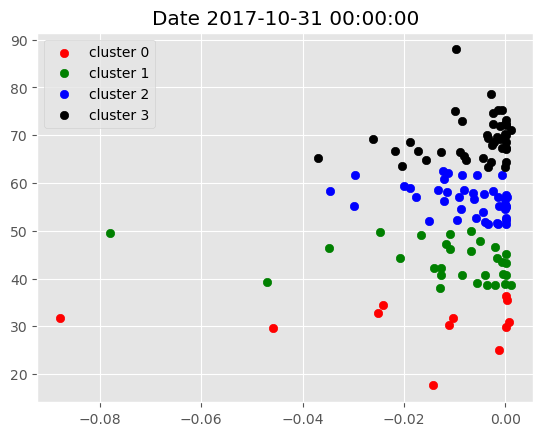

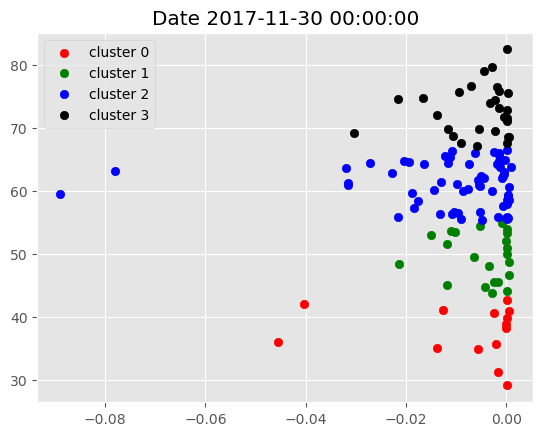

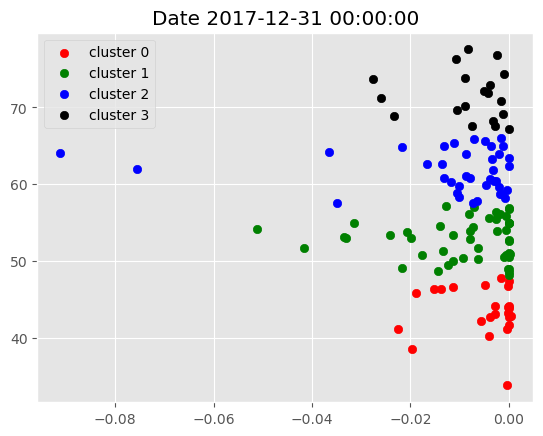

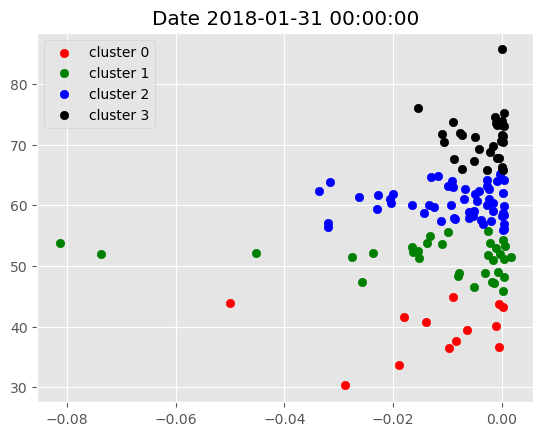

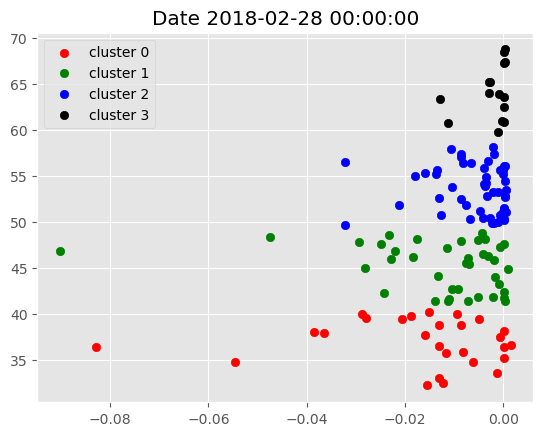

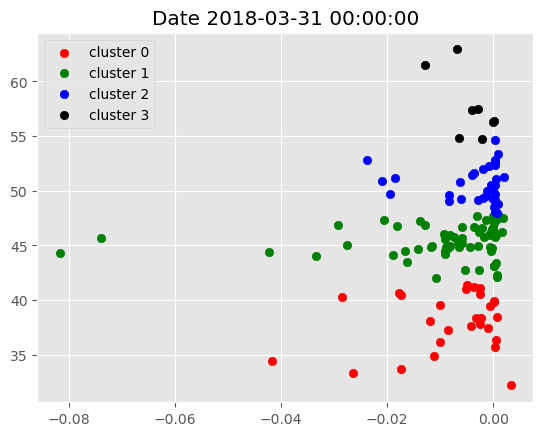

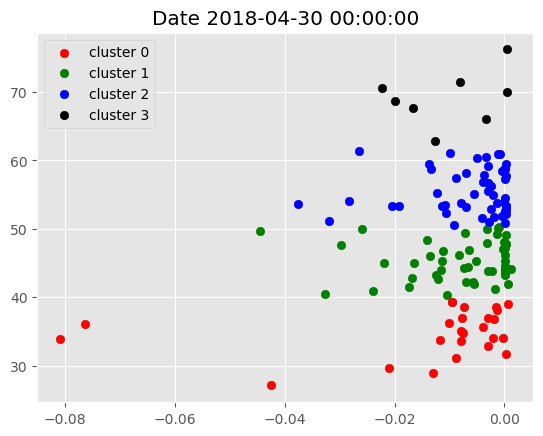

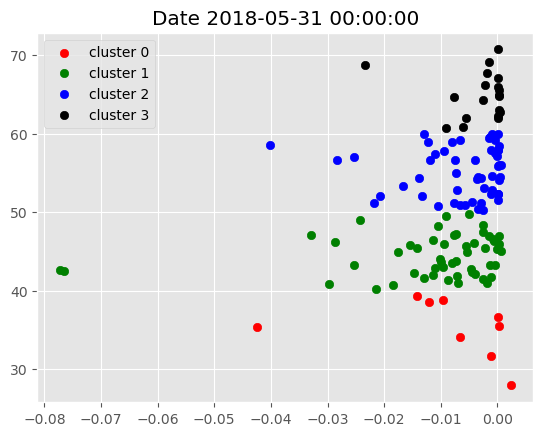

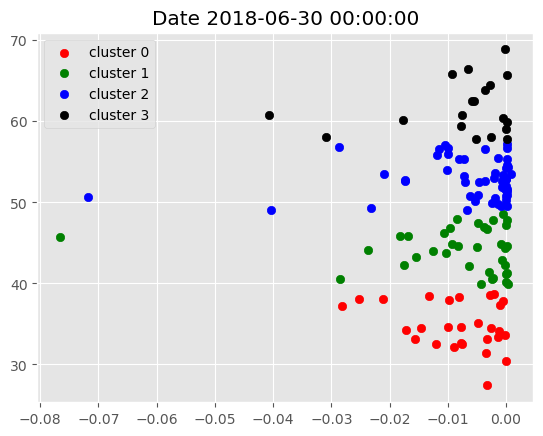

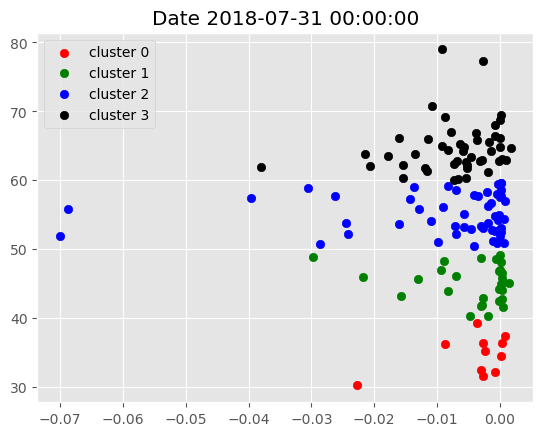

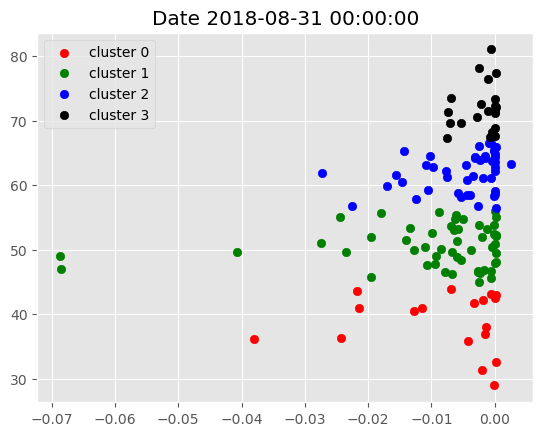

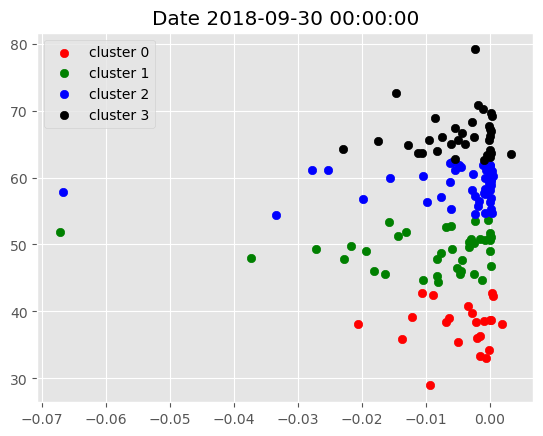

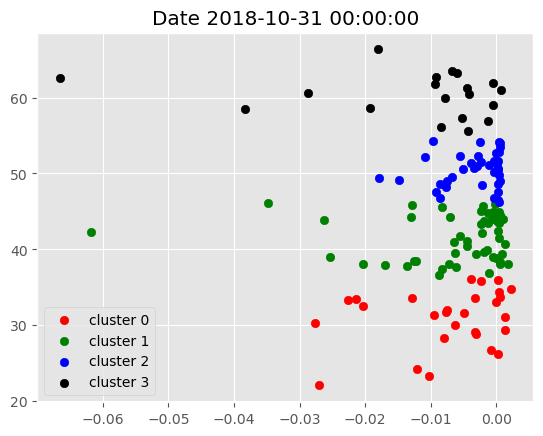

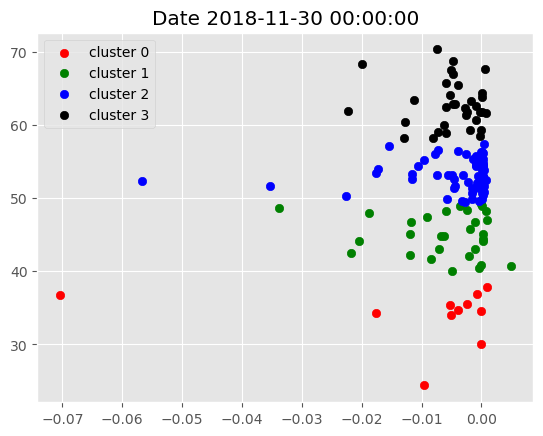

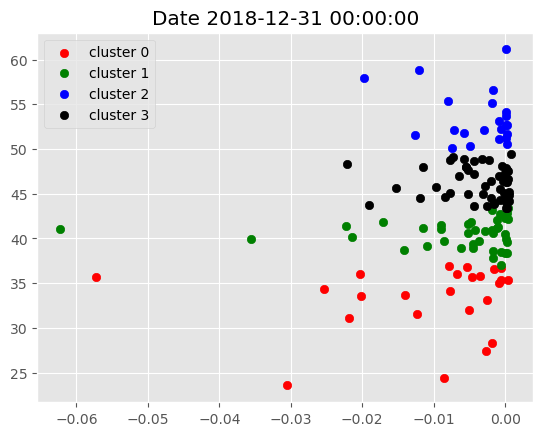

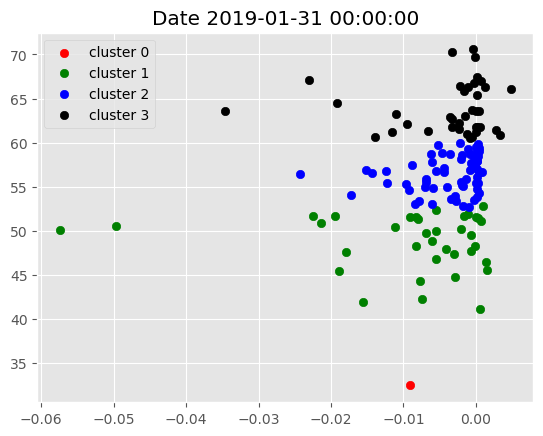

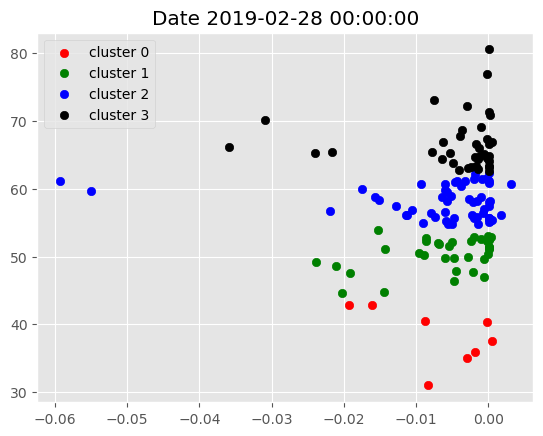

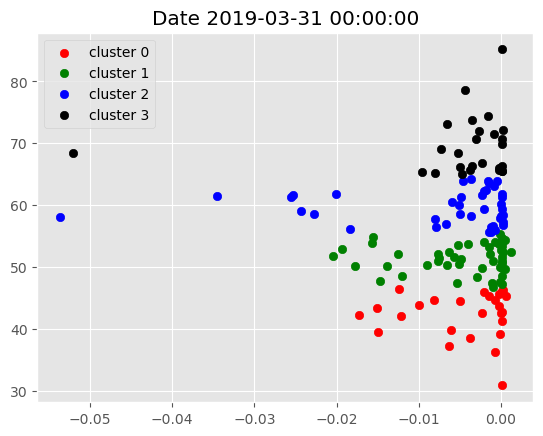

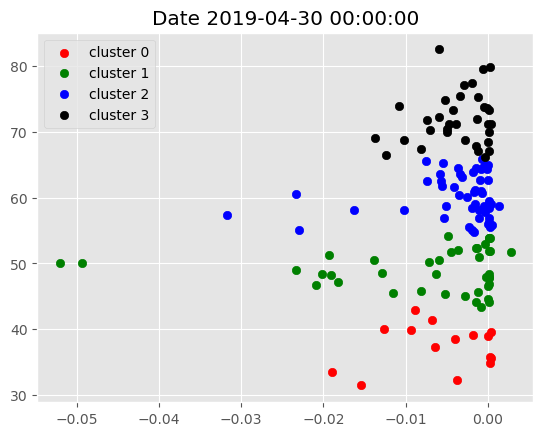

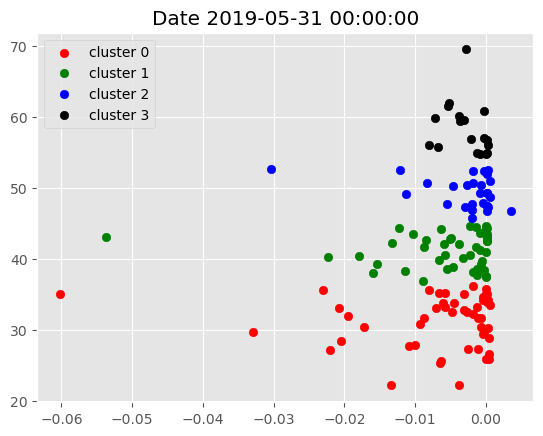

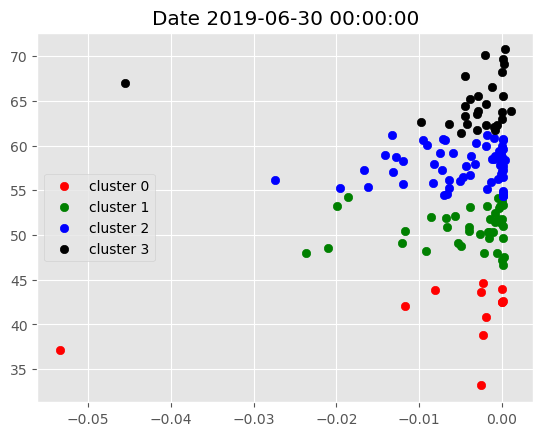

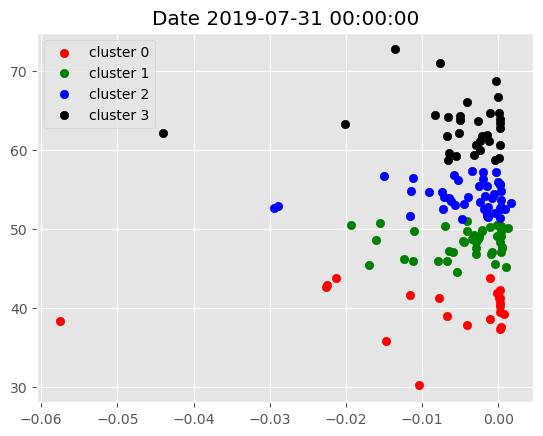

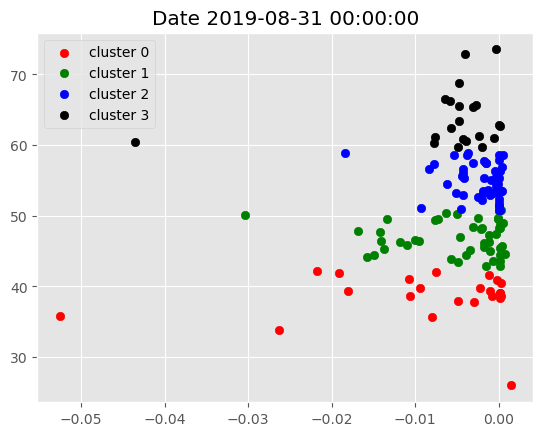

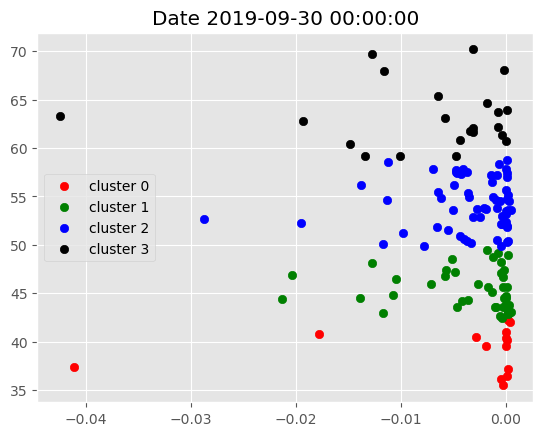

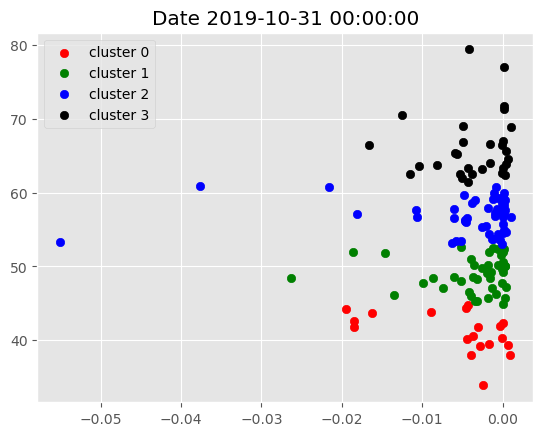

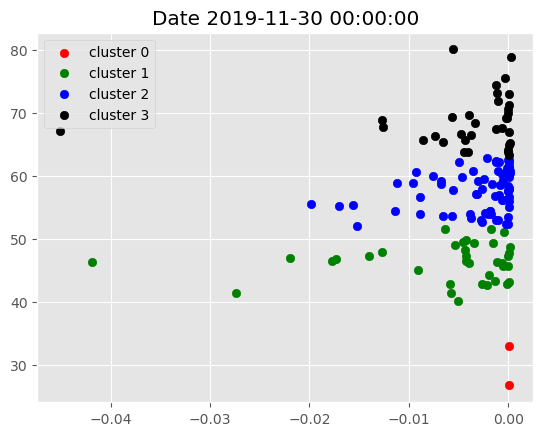

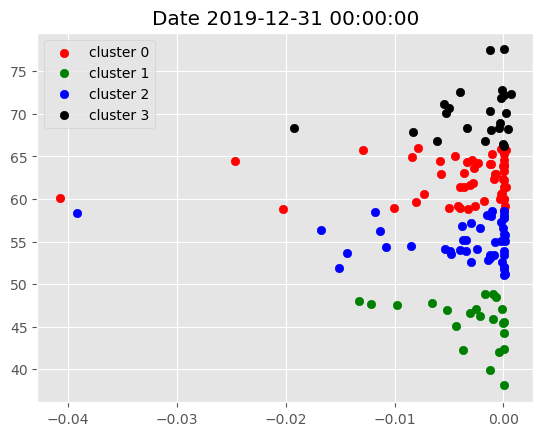

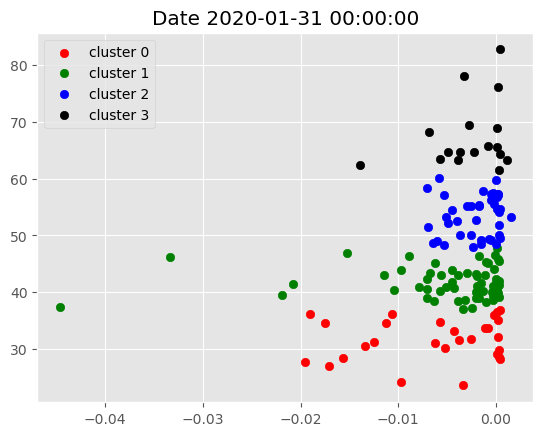

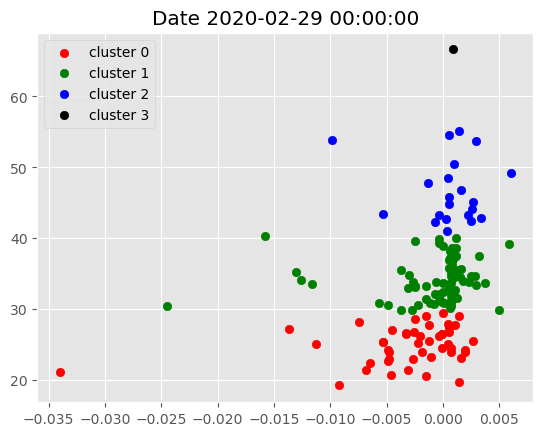

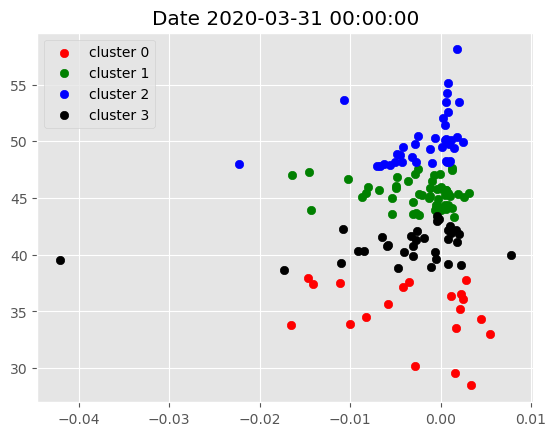

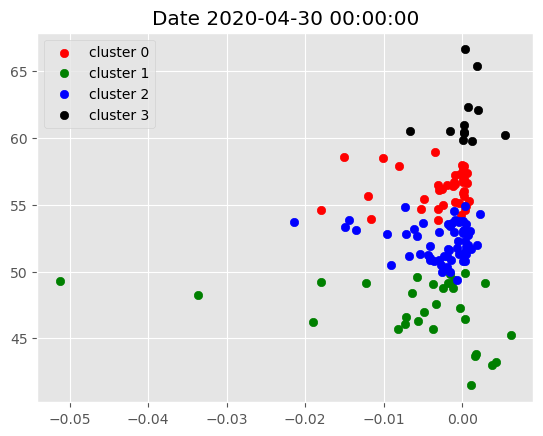

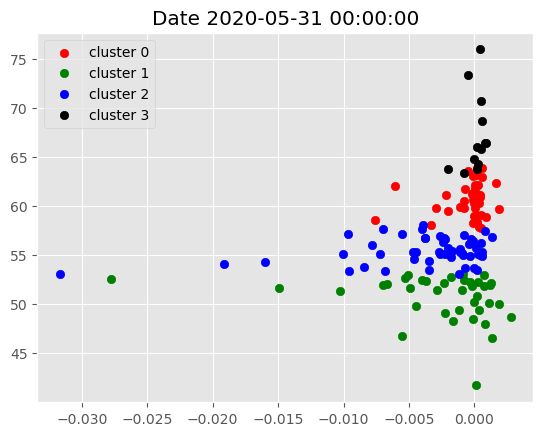

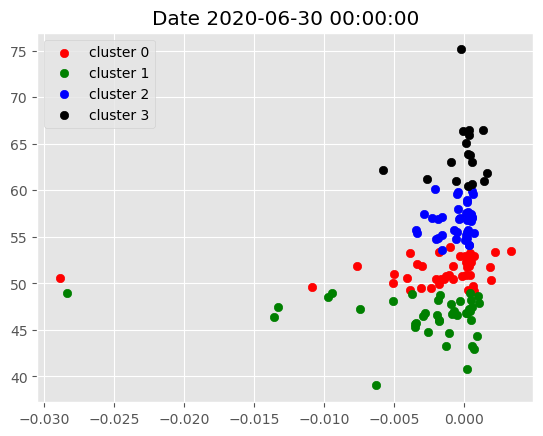

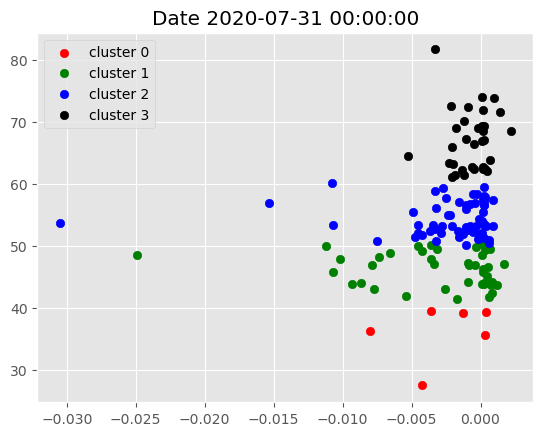

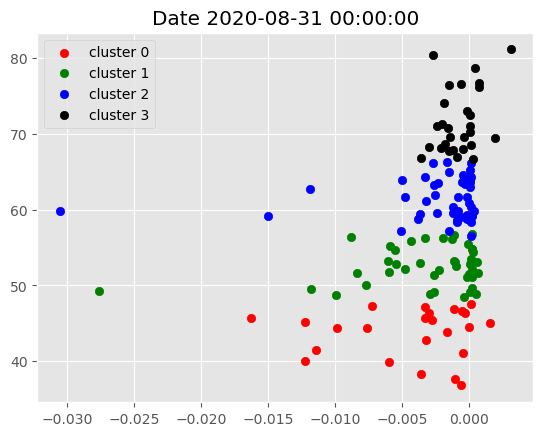

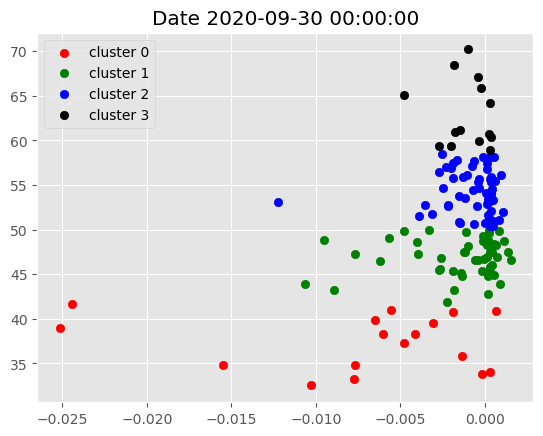

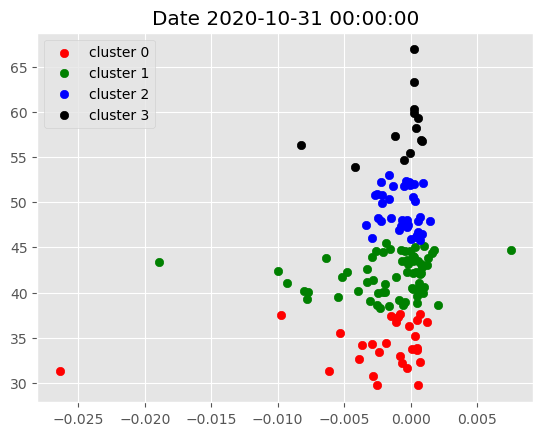

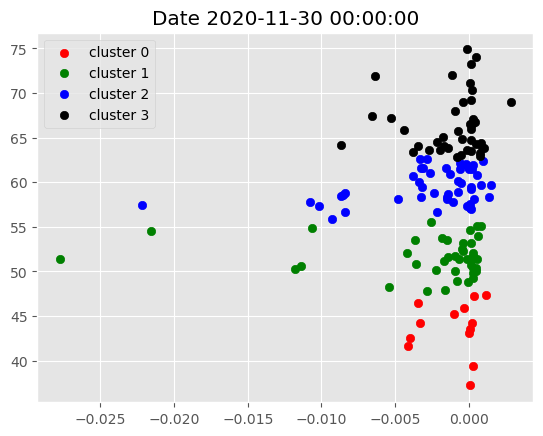

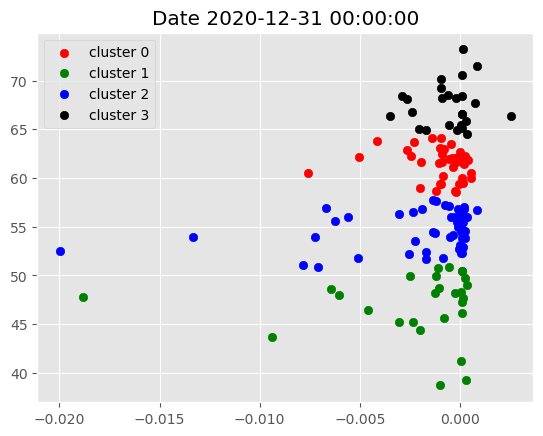

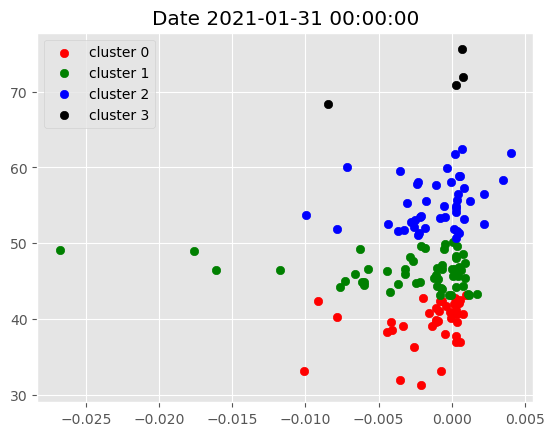

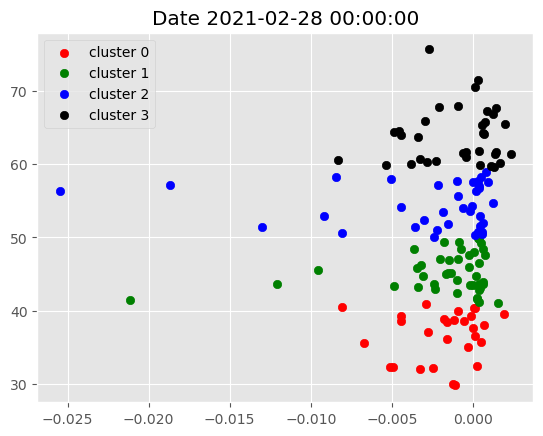

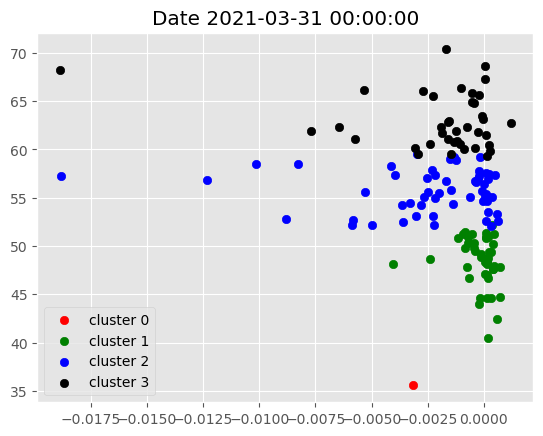

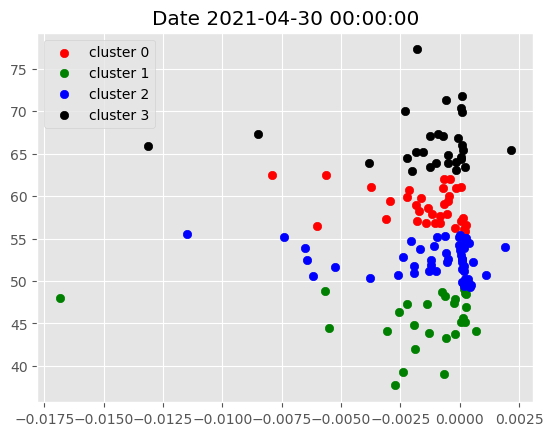

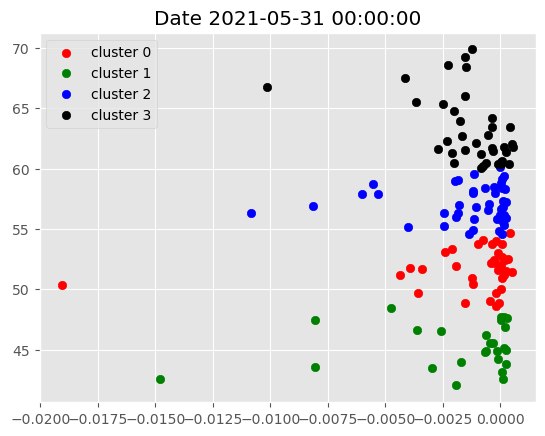

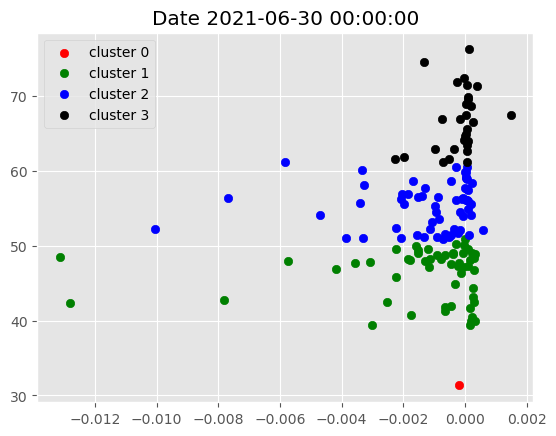

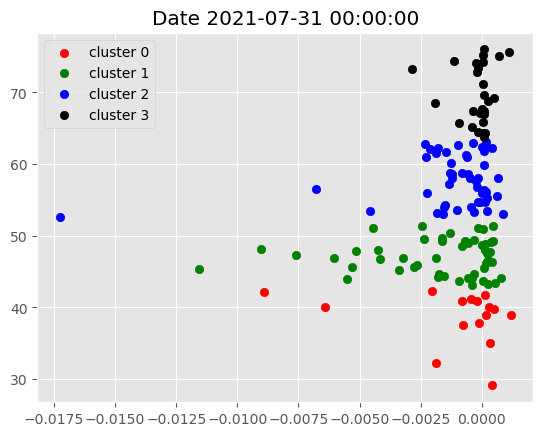

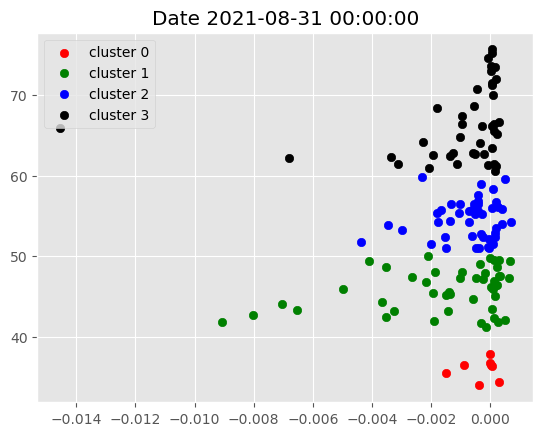

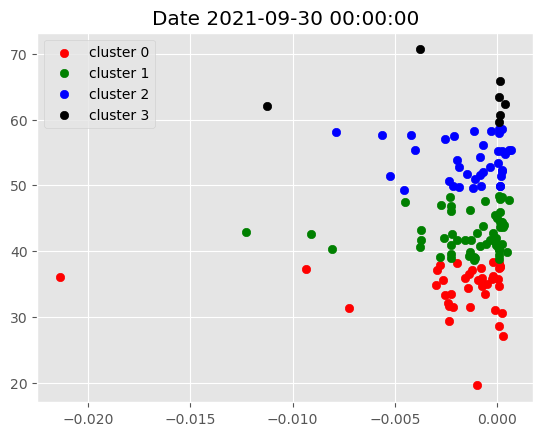

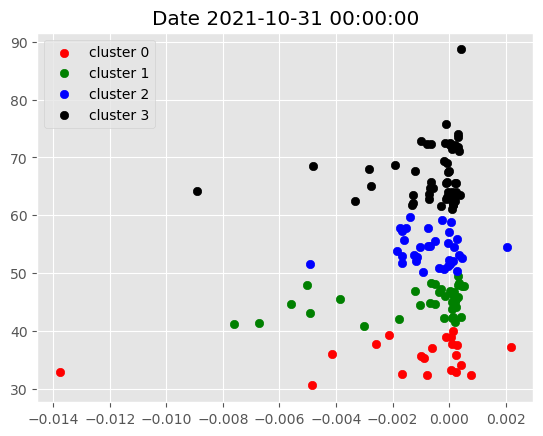

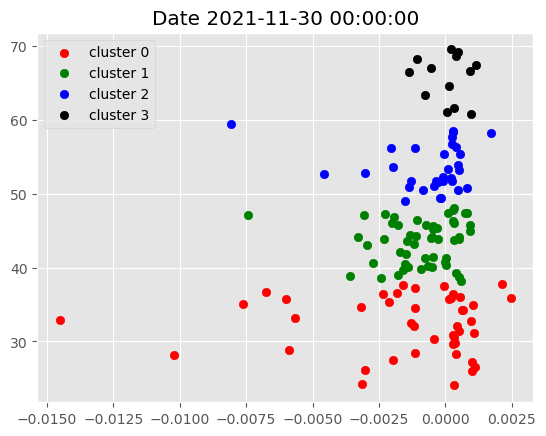

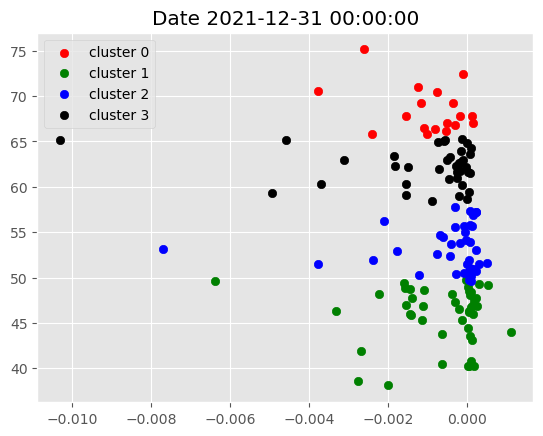

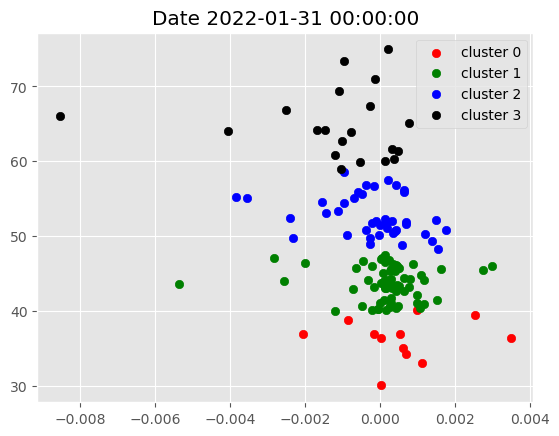

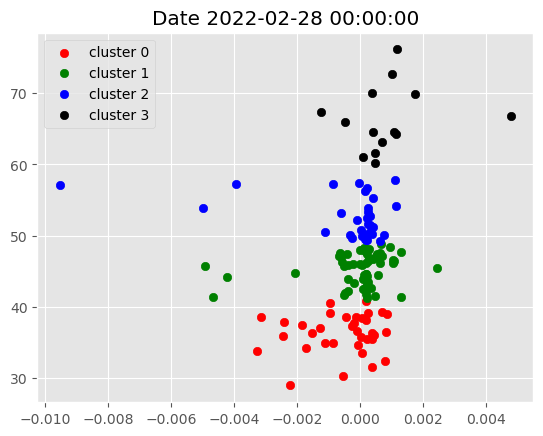

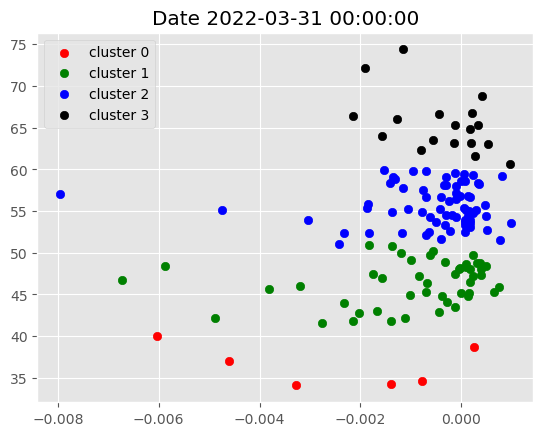

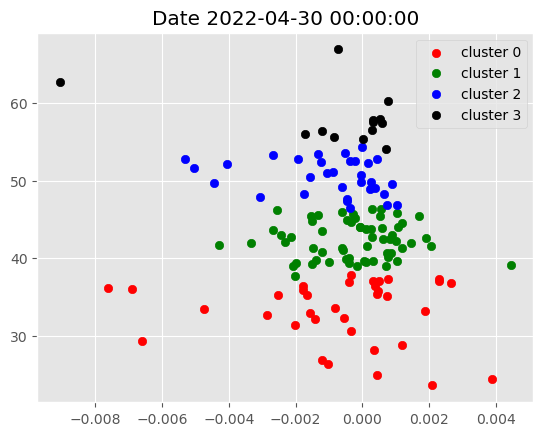

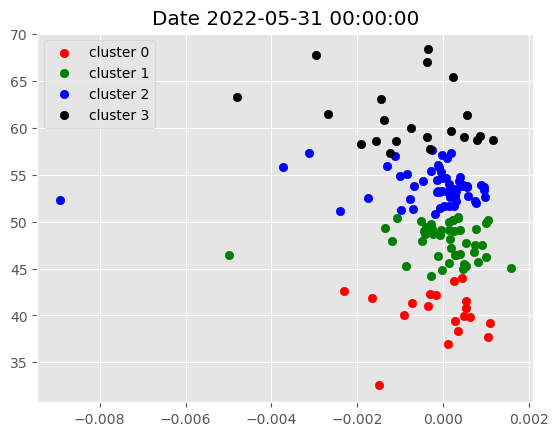

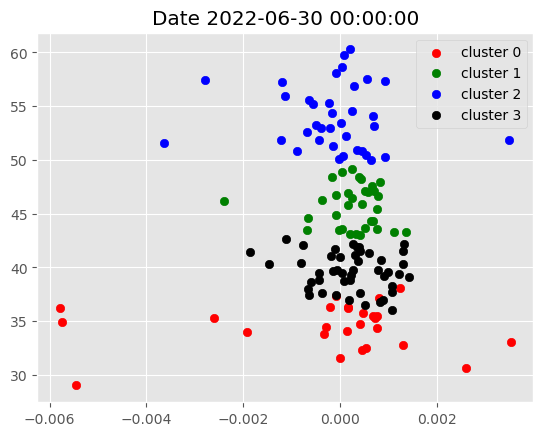

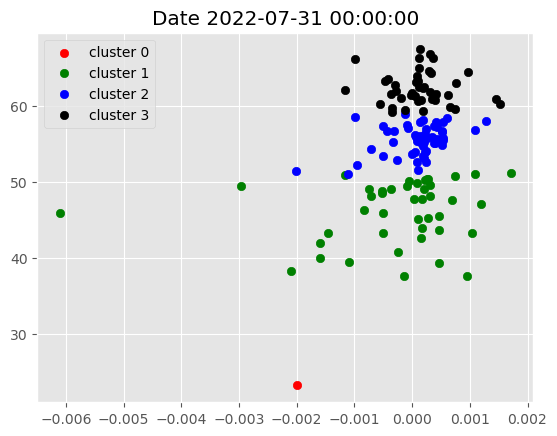

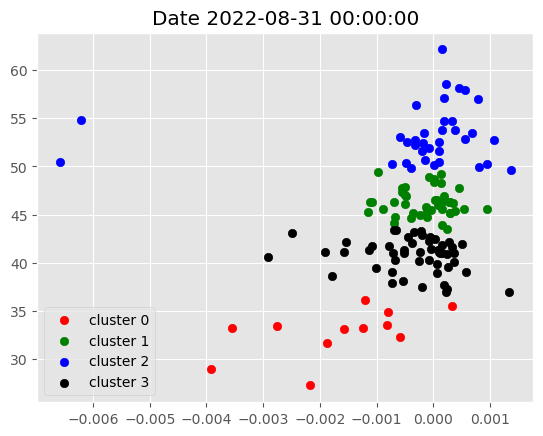

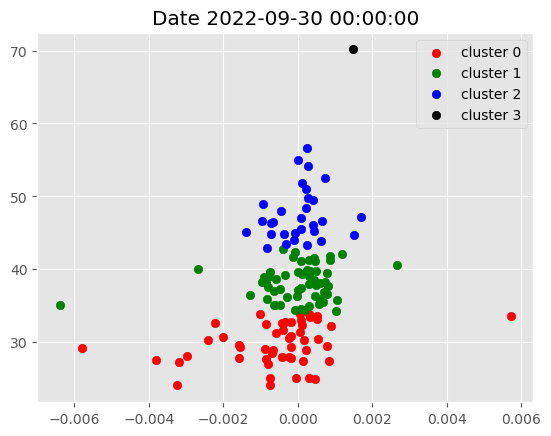

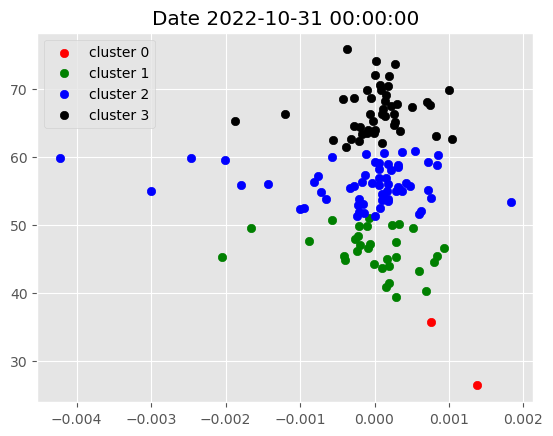

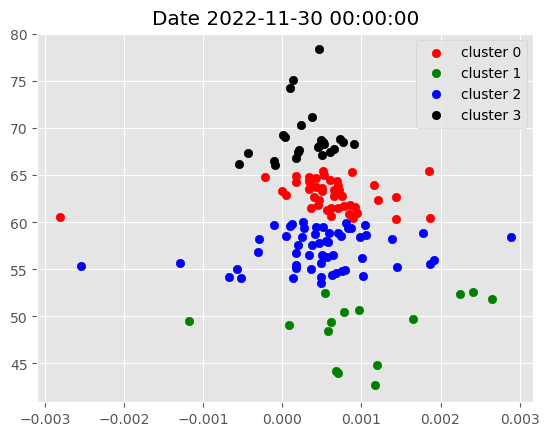

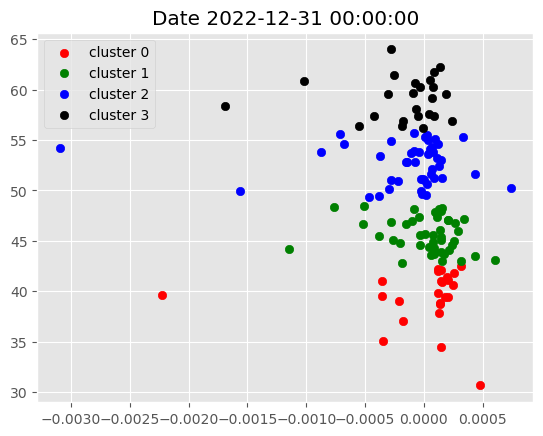

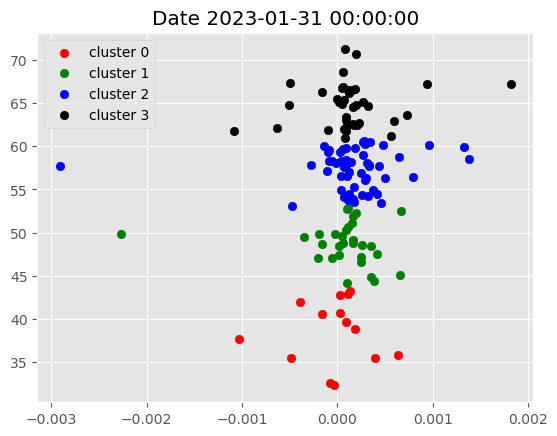

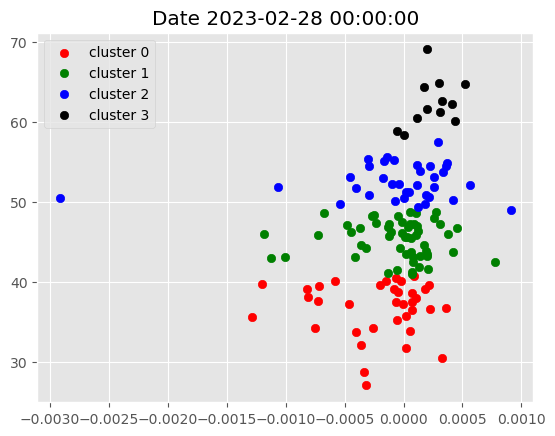

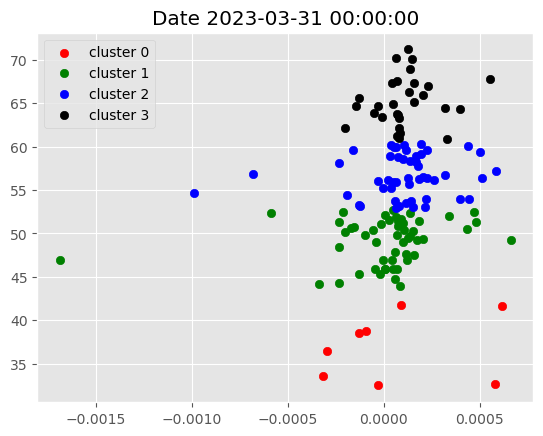

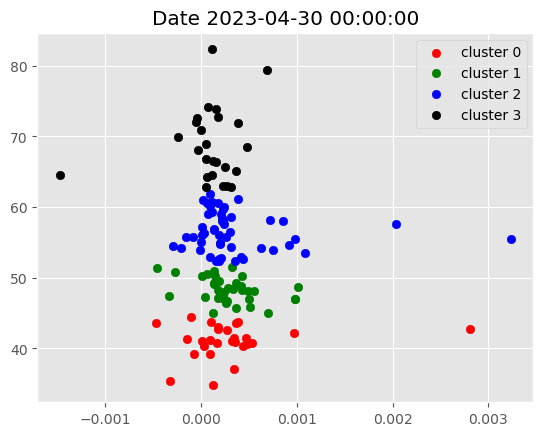

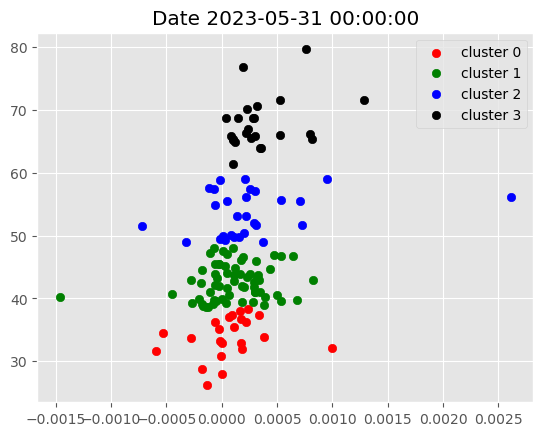

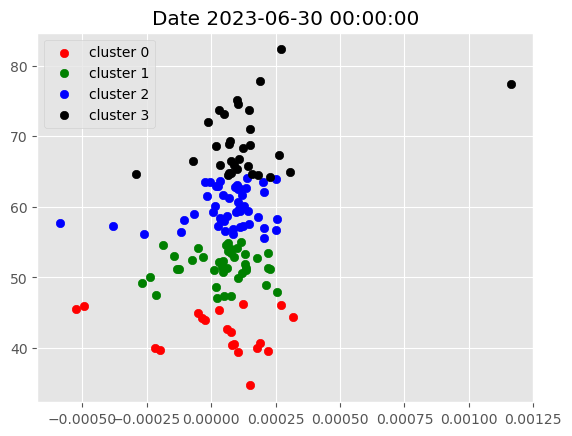

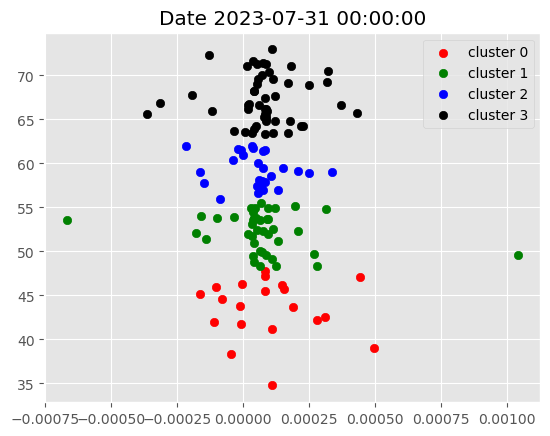

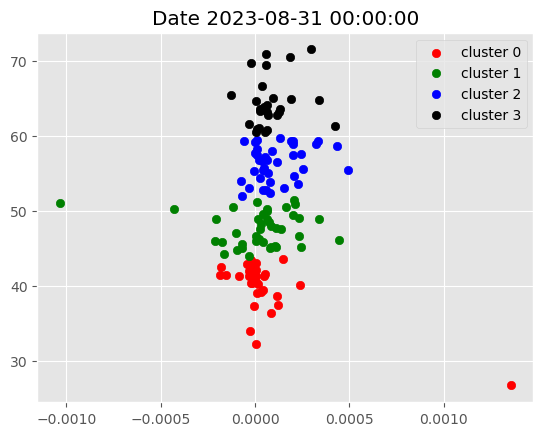

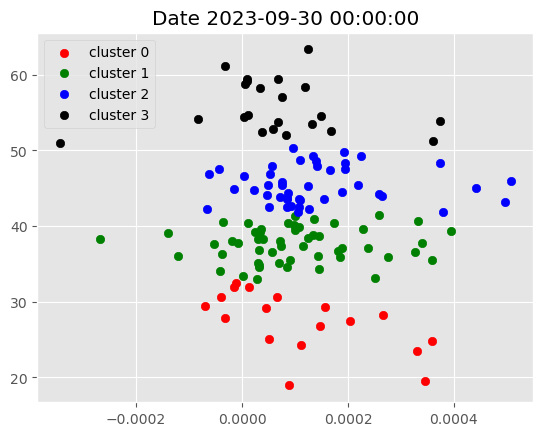

In [91]:
plt.style.use('ggplot')

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

In [95]:
#momentum strategy (invest in stocks that have highest momentum in the last)
#cluster 3 = good momentum through the previous month (around 70 rsi)

In [96]:
#for each month select assets based on the cluster and form portfolio based on efficient frontier max sharpe ratio optimization

In [123]:
filtered_df = data[data['cluster']==3].copy()
filtered_df = filtered_df.reset_index(level=1)

#high rsi last month = buy this month, so increase day by 1
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates #what stock portfolio should look like for each month

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['BA',
  'CAT',
  'CVX',
  'DE',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PXD',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',